**surface_crack_detection_ROBOT_NEURAL_NETWORK _ **

*prageethM*

In [31]:
from PIL import Image
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import seaborn as sns
import cv2

In [32]:
sns.set_style("whitegrid")
positive_dir = '/kaggle/input/surface-crack-detection-dataset/Positive'
negative_dir = '/kaggle/input/surface-crack-detection-dataset/Negative'
num_positive = len(os.listdir(positive_dir))
num_negative = len(os.listdir(negative_dir))

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


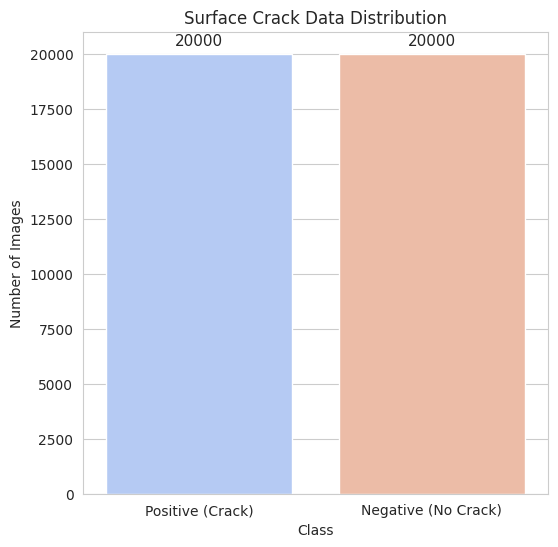

In [33]:
plt.figure(figsize=(6, 6))
sns.barplot(x=['Positive (Crack)', 'Negative (No Crack)'], y=[num_positive, num_negative], palette='coolwarm')
plt.ylabel("Number of Images")
plt.xlabel("Class")
plt.title("Surface Crack Data Distribution")
for index, value in enumerate([num_positive, num_negative]):
    plt.text(index, value + 400, str(value), ha='center', fontsize=11)
plt.show()

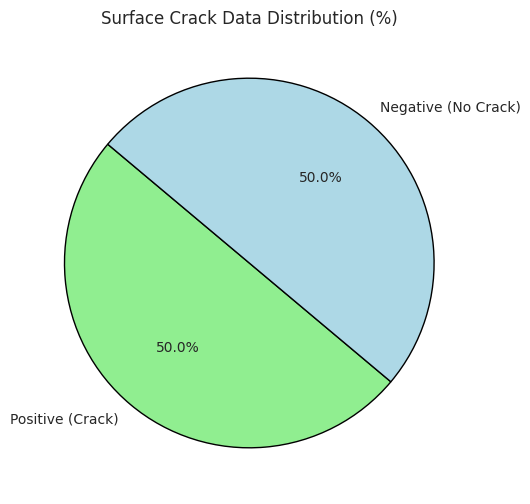

In [34]:
total = num_positive + num_negative
percentages = [num_positive / total * 100, num_negative / total * 100]
labels = ['Positive (Crack)', 'Negative (No Crack)']
colors = ['lightgreen', 'lightblue']
plt.figure(figsize=(6, 6))
plt.pie(percentages, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140, wedgeprops={'edgecolor': 'black'})
plt.title("Surface Crack Data Distribution (%)")
plt.show()

In [35]:
def find_defective_images(directory):
    defective_images = []
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            img = cv2.imread(file_path)
            if img is None:
                defective_images.append(file_path)
                continue
            
            with Image.open(file_path) as img:
                img.verify()

        except (IOError, SyntaxError):
            defective_images.append(file_path)
    
    return defective_images

In [36]:
positive_defects = find_defective_images(positive_dir)
negative_defects = find_defective_images(negative_dir)

print(f"Defective Images in Positive Class: {len(positive_defects)}")
print(f"Defective Images in Negative Class: {len(negative_defects)}")
print("Example Defective Images:", positive_defects[:5] + negative_defects[:5])

Defective Images in Positive Class: 0
Defective Images in Negative Class: 0
Example Defective Images: []


In [37]:
batch_size = 32
img_height = 224
img_width = 224
train_ds = image_dataset_from_directory(
    directory='/kaggle/input/surface-crack-detection-dataset/',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    validation_split=0.2,
    subset="training",
    seed=123
)
val_ds = image_dataset_from_directory(
    directory='/kaggle/input/surface-crack-detection-dataset/',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    validation_split=0.2,
    subset="validation",
    seed=123
)
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

Found 40000 files belonging to 2 classes.
Using 32000 files for training.
Found 40000 files belonging to 2 classes.
Using 8000 files for validation.


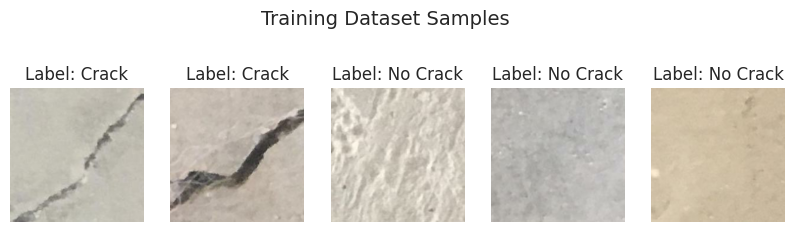

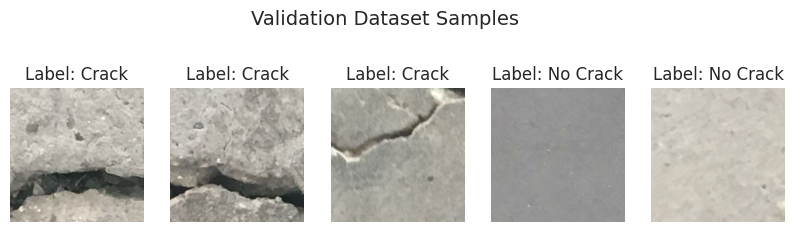

In [38]:
def plot_images_fixed(dataset, title, num_images=5):
    plt.figure(figsize=(10, 3))
    for images, labels in dataset.take(1):
        images = images.numpy() * 255
        labels = labels.numpy()
        for i in range(num_images):
            plt.subplot(1, num_images, i+1)
            plt.imshow(images[i].astype("uint8"), cmap='gray')
            plt.title(f"Label: {'Crack' if labels[i] == 1 else 'No Crack'}")
            plt.axis("off")
    
    plt.suptitle(title, fontsize=14)
    plt.show()
plot_images_fixed(train_ds, "Training Dataset Samples")
plot_images_fixed(val_ds, "Validation Dataset Samples")

In [39]:
base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False

In [40]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [41]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

In [42]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 47s 40ms/step - accuracy: 0.9899 - loss: 1.4529 - val_accuracy: 0.9970 - val_loss: 0.1711 - learning_rate: 1.0000e-04
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 38s 38ms/step - accuracy: 0.9949 - loss: 0.1340 - val_accuracy: 0.9976 - val_loss: 0.0659 - learning_rate: 1.0000e-04
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 38s 38ms/step - accuracy: 0.9956 - loss: 0.0630 - val_accuracy: 0.9976 - val_loss: 0.0481 - learning_rate: 1.0000e-04
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 38s 38ms/step - accuracy: 0.9967 - loss: 0.0443 - val_accuracy: 0.9971 - val_loss: 0.0456 - learning_rate: 1.0000e-04
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 38s 38ms/step - accuracy: 0.9960 - loss: 0.0469 - val_accuracy: 0.9977 - val_loss: 0.0382 - learning_rate: 1.0000e-04
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 38s 38ms/step - accuracy: 0.9962 - loss: 0.0396 - val_accuracy: 0.9976 - val_loss: 0.0298 - learning_rate: 1.0000e-04
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━

In [43]:
base_model.trainable = True
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 163s 121ms/step - accuracy: 0.9527 - loss: 0.1505 - val_accuracy: 0.9716 - val_loss: 0.1003 - learning_rate: 1.0000e-05
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 118s 118ms/step - accuracy: 0.9957 - loss: 0.0225 - val_accuracy: 0.9959 - val_loss: 0.0184 - learning_rate: 1.0000e-05
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 118s 118ms/step - accuracy: 0.9979 - loss: 0.0153 - val_accuracy: 0.9989 - val_loss: 0.0126 - learning_rate: 1.0000e-05
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 118s 118ms/step - accuracy: 0.9985 - loss: 0.0123 - val_accuracy: 0.9990 - val_loss: 0.0116 - learning_rate: 1.0000e-05
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 119s 119ms/step - accuracy: 0.9989 - loss: 0.0107 - val_accuracy: 0.9989 - val_loss: 0.0108 - learning_rate: 1.0000e-05


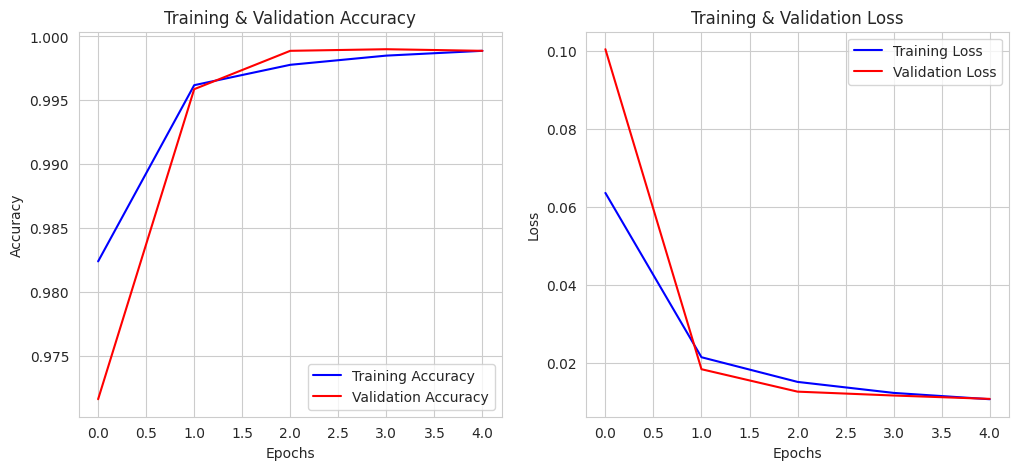

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy", color='blue')
plt.plot(epochs_range, val_acc, label="Validation Accuracy", color='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss", color='blue')
plt.plot(epochs_range, val_loss, label="Validation Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

In [ ]:
'''y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    preds = np.round(preds).astype(int).flatten()
    y_pred.extend(preds)
    y_true.extend(labels.numpy())
print(classification_report(y_true, y_pred, target_names=['No Crack', 'Crack']))'''

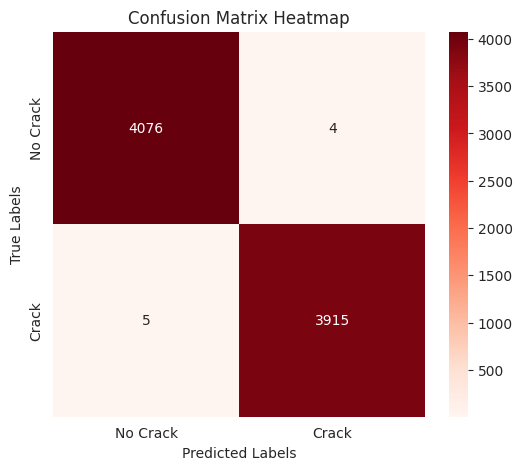

In [51]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=['No Crack', 'Crack'], yticklabels=['No Crack', 'Crack'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Heatmap")
plt.show()

In [52]:
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9989 - loss: 0.0115
Validation Accuracy: 99.89%


In [53]:
model.save("crack_detection_mobilenetv2.h5")

In [54]:
loaded_model = keras.models.load_model("crack_detection_mobilenetv2.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


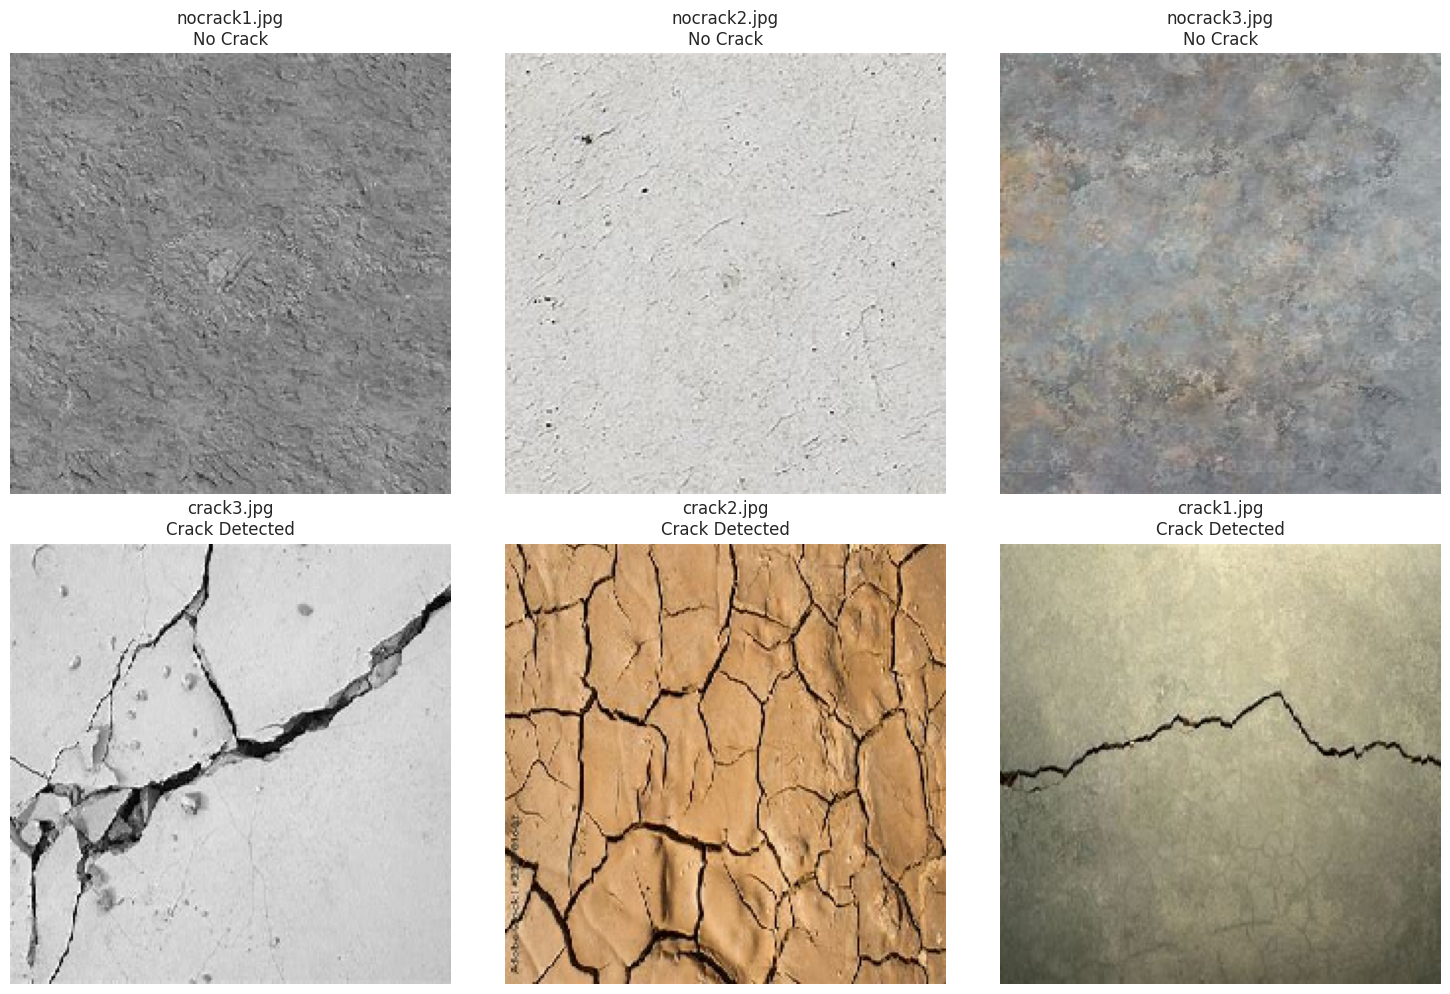

In [57]:
def predict_images(folder_path, model):
    img_paths = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.endswith(('jpg', 'png'))]
    fig, axes = plt.subplots(int(np.ceil(len(img_paths)/3)), 3, figsize=(15, 5 * int(np.ceil(len(img_paths)/3))))
    
    for ax, img_path in zip(axes.flatten(), img_paths):
        img = keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        img_array = np.expand_dims(keras.preprocessing.image.img_to_array(img), axis=0) / 255.0
        result = "Crack Detected" if model.predict(img_array)[0][0] > 0.5 else "No Crack"
        ax.imshow(img), ax.set_title(f"{os.path.basename(img_path)}\n{result}"), ax.axis('off')
    
    for ax in axes.flatten()[len(img_paths):]: ax.axis('off')
    plt.tight_layout(), plt.show()

predict_images('/kaggle/input/test-images-01/cracks/', loaded_model)